<a href="https://colab.research.google.com/github/Jimin980921/Do-it_DeepLearning/blob/master/Do_it_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
w=np.array([[2,0],[0,0]])


In [2]:
import tensorflow as tf
tf.enable_eager_execution()
x_4d=x.astype(np.float).reshape(1,3,3,1)
w_4d=w.reshape(2,2,1,1)

# 합성곱

In [0]:
c_out=tf.nn.conv2d(x_4d,w_4d,strides=1,padding='SAME')
#결과값으로 tensor객체를 반환. 다차원배열을 텐서라고 부름. tensor객체의 numpy()메서드를 사용하면 텐서를 배열로 변환가능

In [4]:
#배치차원과 컬러차원을 제거하고 (3,3)크기로 변환하여 출력
from scipy.signal import convolve2d
from scipy.signal import convolve
from scipy.signal import correlate
from scipy.signal import correlate2d
c_out.numpy().reshape(3,3)
#4차원배열 출력

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [0]:
#최대풀링, 평균풀링
x=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
x=x.reshape(1,4,4,1)

In [6]:
#max_Pool2d함수로 최대풀링 수행. 풀링크기(보통 2X2)를 ksize,스트라이드크기(보통 풀링의 한 모서리크기)는 strides변수에 대입
#max_pool2d가 반환한 tensor객체를 numpy()메서드로 변환해줌.  
p_out=tf.nn.max_pool2d(x,ksize=2,strides=2,padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6,  8],
       [14, 16]])

# RELU 함수

In [0]:
#0보다 크면 자기자신, 0보다 작으면 0 출력
def relu(x):
  return np.maximum(x,0)

In [8]:
x=np.array([-1,2,-3,4,-5])
relu(x)


array([0, 2, 0, 4, 0])

In [9]:
#텐서플로가 제공하는 렐루함수
#tensor객체로 반환하므로 화면에 출력하려면 넘파이로 변환해야함.
r_out=tf.nn.relu(x)
r_out.numpy()


array([0, 2, 0, 4, 0])

# 합성곱 신경망을 생성 및 훈련

In [0]:
class ConvolutionNetwork:

  def init(self,n_kernels=10,units=10,batch_size=32,learning_rate=0.1):
    self.n_kernels=n_kernels
    self.kernel_size=3
    self.optimizer=None
    self.conv_w=None  #가중치
    self.conv_b=None  #절편
    self.units=units  #은닉층 뉴런갯수
    self.batch_size=batch_size  #배치크기
    self.w1=None
    self.b1=None
    self.w2=None
    self.b2=None
    self.a1=None   #은닏층 활성화 출력
    self.losses=[]
    self.val_losses=[]
    self.lr=learning_rate

  def forpass(self,x):
    #합성곱 연산
    c_out=tf.nn.conv2d(x,self.conv_w,strides=1,padding='SAME')+self.conv_b
    #렐루 활성화함수
    r_out=tf.nn.relu(c_out)
    #2*2최대 풀링적용
    p_out=tf.nn.max_pool2d(r_out,ksize=2,strides=2,padding='VALID')
    #첫번째 배치 차원 제외하고 일렬로 펼침
    f_out=tf.reshape(p_out,[x.shape[0],-1])
    z1=tf.matmul(f_out,self.w1)+self.b1  #완전연결층의 첫번째 선형식계산
    a1=tf.nn.relu(z1) #활성화함수적용
    z2=tf.matmul(a1,self.w2)+self.b2 #두번째 선형식계산
    return z2  

  def init_weights(self,input_shape,n_classes):  #가중치 초기화
    g=tf.initializers.glorot_uniform() #올바른 최적점을 시작으로 할 수 있게 도와주는 가중치 초기화 함수
    self.conv_w=tf.Variable(g((3,3,1,self.n_kernels)))
    self.conv_b=tf.Variable(np.zeros(self.n_kernels),dtype=float)
    n_features=14*14*self.n_kernels  #?
    self.w1=tf.Variable(g((n_features,self.units)))     #??
    self.b1=tf.Variable(np.zeros(self.units),dtype=float)
    self.w2=tf.Variable(g((self.units,n_classes)))
    self.b2=tf.Variable(np.zeros(n_classes),d_type=float)

  def fit(self,x,y,epochs=100,x_val=None,y_val=None):
    self.init_weights(x.shape,y.shape[1])  #은닉층의 가중치, 츨력층의 가중치 초기화
    self.optimizer=tf.optimizers.SGD(learning_rate=self.lr)    #경사하강법

    for i in range(epochs):
      print('에포크',i, end=' ')
      #제네레이터 함수에서 반환한 미니배치 순환
      batch_losses=[]
      for x_batch,y_batch in self.gen_batch(x,y):
        print('.',end='')
        self.training(x_batch,y_batch)
        #배치 손실 기록
        batch_losses.append(self.get_loss(x_batch,y_batch))
      print()
      self.losses.append(np.mean(batch_losses))  #배치손실평균
      self.val_losses.append(self.get_loss(x_val,y_val))  #검증세트에대한 손실 저장

    def gen_batch(self,x,y):  #미니배치 제너레이터 함수
      bins=len(x)//self.batch_size
      #인덱스 섞기
      indexes=np.random.permutation(np.arrange(len(x)))
      x=x[indexes]
      y=y[indexes]
      for i in range(bins):
        start=self.batch_size*i   
        end=self.batch_size*(i+1) 
        yield x[start:end],y[start:end]

    def training(self,x,y):  #무슨과정?
      m=len(x) #샘플갯수저장
      with tf.GradientTape() as tape:   #자동미분법
        z=self.forpass(x)   #정방향계산수행
        #손실계산
        loss=tf.nn.softmax_cross_entropy_with_logits(y,z)   #?
        loss=tf.reduce_mean(loss)

      weights_list=[self.conv_w,self.conv_b,self.w1,self.b1,self.w2,self.b2]
      #가중치에대한 그레디언트 계산
      grads=tape.gradient(loss,weights_list)  #자동미분(tape), 파라미터 왜?
      #가중치 업데이트
      self.optimizer.apply_gradients(zip(grads,weights_list))

    def predict(self,x):
      z=self.forpass(x)
      return np.argmax(z.numpy(),axis=1)  #가장큰값의 인덱스 반환

    def score(self,x,y):
      return np.mean(self.predict(x)==np.argmax(y,axis=1))   #y값과 비교

    def get_loss(self,x,y):
      z=self.forpass(x)
      #손실계산해서 저장
      loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))   #?????
      return loss.numpy()



In [0]:
#데이터 세트 불러오기
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [0]:
#훈련데이터를 훈련세트와 검증세트로 나누기
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)


In [0]:
#타깃을 원-핫 인코딩으로 변환
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [0]:
#입력데이터 준비
x_train=x_train.reshape(-1,28,28,1)
x_val=x_val.reshape(-1,28,28,1)

In [23]:
x_train.shape

(48000, 28, 28, 1)

In [0]:
#입력데이터 표준화 전처리
x_train=x_train/255  #픽셀은 0-255사이값으로 표현. 경사하강법 사용을 위해 255로 나눠줌(0-1)
x_val=x_val/255


In [28]:
#모델 훈련하기
cn=ConvolutionNetwork(n_kernels=10,units=100,batch_size=128,learning_rate=0.01)
cn.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs=20)  

TypeError: ignored

# 케라스로 합성곱 신경망

In [32]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
#합성곱층 쌓기
conv1=tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
#풀링층쌓기
conv1.add(MaxPooling2D((2,2)))
#완전연결층에 연결하도록 특성맵 펼치기
conv1.add(Flatten())
#완전연결층에 쌓기
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation='softmax'))

#모델 구조 살펴보기
conv1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [0]:
#합성곱 신경망모델 훈련하기
conv1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
history=conv1.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 22s 461us/sample - loss: 0.4730 - acc: 0.8317 - val_loss: 0.3405 - val_acc: 0.8818
Epoch 2/20
48000/48000 [==============================] - 22s 456us/sample - loss: 0.3220 - acc: 0.8839 - val_loss: 0.3042 - val_acc: 0.8901
Epoch 3/20
48000/48000 [==============================] - 22s 450us/sample - loss: 0.2716 - acc: 0.9002 - val_loss: 0.2842 - val_acc: 0.9017
Epoch 4/20
48000/48000 [==============================] - 21s 442us/sample - loss: 0.2392 - acc: 0.9129 - val_loss: 0.2463 - val_acc: 0.9133
Epoch 5/20
48000/48000 [==============================] - 21s 441us/sample - loss: 0.2103 - acc: 0.9223 - val_loss: 0.2508 - val_acc: 0.9111
Epoch 6/20
48000/48000 [==============================] - 22s 452us/sample - loss: 0.1885 - acc: 0.9294 - val_loss: 0.2447 - val_acc: 0.9162
Epoch 7/20
48000/48000 [==============================] - 21s 448us/sample - loss: 0.1697 - acc: 0.9374 

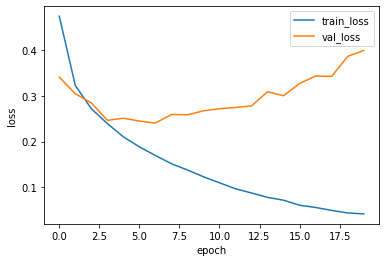

In [36]:
#손실그래프와 정확도 그래프 확인하기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

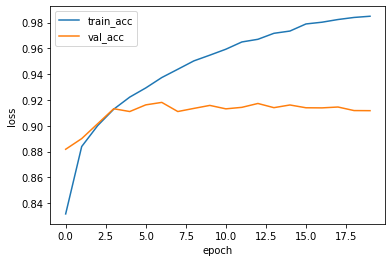

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [42]:
#정확도
loss,accuracy=conv1.evaluate(x_val,y_val_encoded,verbose=0)
print(loss)
print(accuracy)

0.3985147605802243
0.91175


In [0]:
#드롭아웃 적용하여 합성곱 신경망 구현
from tensorflow.keras.layers import Dropout
conv2=tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))  #합성곱
conv2.add(MaxPooling2D((2,2,)))  #풀링

In [0]:
conv2.add(Flatten())
conv2.add(Dropout(0.5))  #드롭아웃
conv2.add(Dense(100,activation='relu'))  #뉴런 100개
conv2.add(Dense(10,activation='softmax'))  #뉴런 10개

In [47]:
conv2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [0]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 24s 492us/sample - loss: 0.5219 - acc: 0.8113 - val_loss: 0.3686 - val_acc: 0.8669
Epoch 2/20
48000/48000 [==============================] - 24s 491us/sample - loss: 0.3773 - acc: 0.8649 - val_loss: 0.3235 - val_acc: 0.8807
Epoch 3/20
48000/48000 [==============================] - 23s 484us/sample - loss: 0.3341 - acc: 0.8790 - val_loss: 0.2830 - val_acc: 0.8997
Epoch 4/20
48000/48000 [==============================] - 23s 479us/sample - loss: 0.3086 - acc: 0.8867 - val_loss: 0.2645 - val_acc: 0.9067
Epoch 5/20
48000/48000 [==============================] - 23s 479us/sample - loss: 0.2881 - acc: 0.8946 - val_loss: 0.2592 - val_acc: 0.9089
Epoch 6/20
48000/48000 [==============================] - 23s 480us/sample - loss: 0.2724 - acc: 0.8980 - val_loss: 0.2487 - val_acc: 0.9119
Epoch 7/20
48000/48000 [==============================] - 23s 471us/sample - loss: 0.2612 - acc: 0.9019 

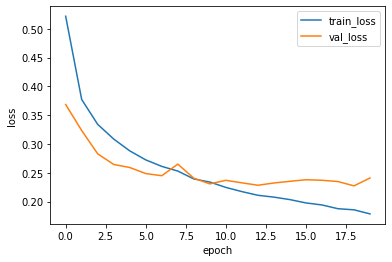

In [50]:
#손실함수
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

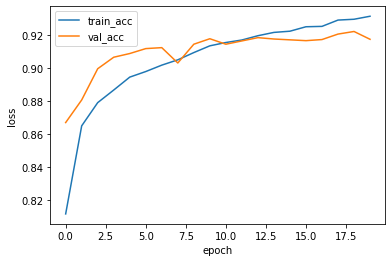

In [53]:
#정확도함수
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [52]:
#정확도
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.91758335
